This notebook is inspired from the tensorflow official website :
(Well explained and so informative)
https://www.tensorflow.org/text/tutorials/transformer







** Useful Links, to understand transformers architecture: **

R1
https://towardsdatascience.com/transformers-explained-visually-part-1-overview-of-functionality-95a6dd460452  
Please check the 4 blogs (Part1 => part4)


R2:
https://towardsdatascience.com/illustrated-guide-to-transformers-step-by-step-explanation-f74876522bc0

** The overAll architecture **

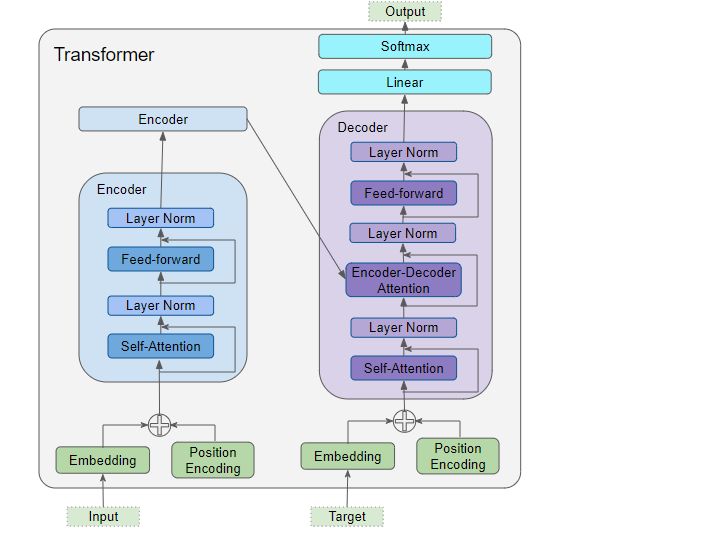

### The Scaled Dot Product Attention

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

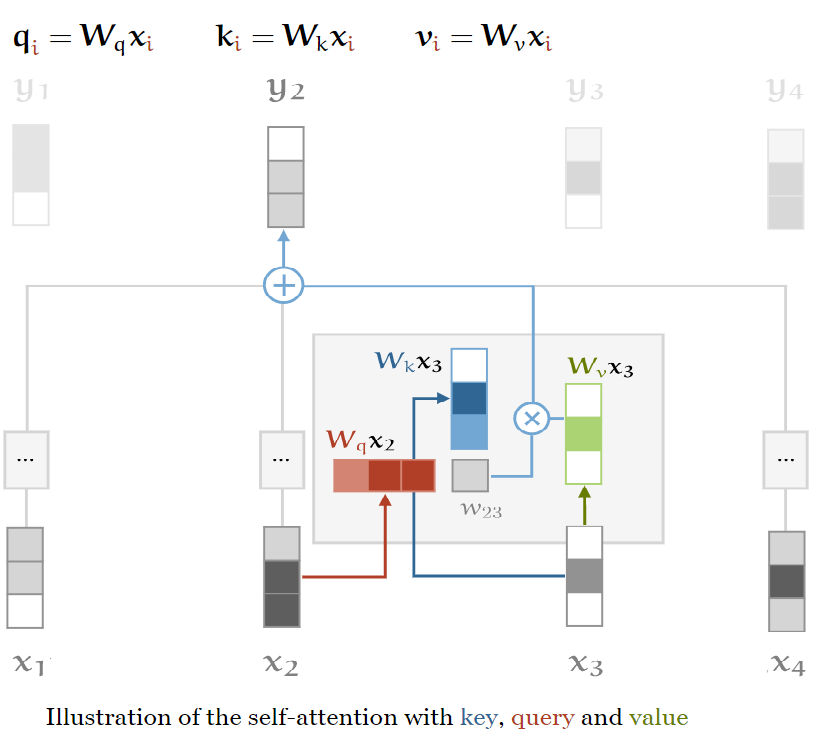

In [4]:
def scaled_dp_attention(queries, keys, values, mask):
  #print("queries: ",queries.shape)
  #print("keys: ",keys.shape)
  #print("values: ",values.shape)
  product = tf.matmul(queries, keys, transpose_b=True)
  #print("product: ",product.shape)

  keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
  scaled_product = product/tf.math.sqrt(keys_dim)
  #print(scaled_product.shape)

  if mask is not None:
    scaled_product +=  (mask*(-1e20))
    # -inf is set to a big number
  attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), 
                        values)
  #print("attention: ",attention.shape)
  return attention

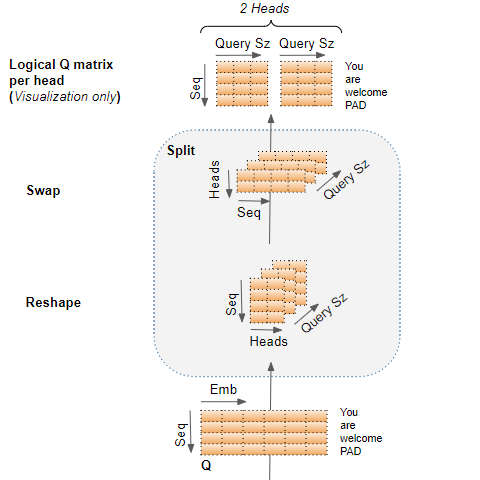

In [5]:
class multi_head_attention(layers.Layer):
  def __init__(self,n_heads,d_model):
    super(multi_head_attention, self).__init__()
    self.n_heads = n_heads
    self.d_model = d_model

#  def built(self, input_shape):
#    self.d_model =input_shape[-1]
    # Weights for Queries, Keys and Values:
    self.query_linear = layers.Dense(self.d_model)    
    self.key_linear = layers.Dense(self.d_model)    
    self.value_linear = layers.Dense(self.d_model)    
    self.final_linear = layers.Dense(self.d_model)

    assert d_model % self.n_heads == 0
    self.d_head = d_model // n_heads
  def split_projection(self, inputs, batch_size):
    shape = (batch_size, -1, self.n_heads, self.d_head)
    splited_inputs = tf.reshape(inputs, shape=shape)
    return tf.transpose(splited_inputs, perm=[0,2,1,3])
      # batch_size, n_heads, d_model, d_heads

  def call (self, queries, keys, values, mask):
    batch_size = tf.shape(queries)[0]
    queries = self.query_linear(queries)    
    keys = self.key_linear(keys)      
    values = self.value_linear(values)
#    print("queries shape:      ", queries.shape)
    queries = self.split_projection(queries, batch_size)
    keys = self.split_projection(keys, batch_size)
    values = self.split_projection(values, batch_size)
#    print("queries shape:      ", queries.shape)
    attention = scaled_dp_attention(queries, keys, values, mask)
    attention = tf.transpose(attention, perm=[0,2,1,3])

    concat_attention = tf.reshape(attention, shape=(batch_size,-1, self.d_model))
    outputs = self.final_linear(concat_attention)

    return outputs


In [8]:
#multi_head = multi_head_attention(28,224)

In [9]:
#print(multi_head(x,x,x, None).shape)

### Positional Encoding

Explanation: 
https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

Why positional embeddings are summed with word embeddings instead of concatenation?

https://github.com/tensorflow/tensor2tensor/issues/1591

https://www.reddit.com/r/MachineLearning/comments/cttefo/d_positional_encoding_in_transformer/exs7d08/ 


https://datascience.stackexchange.com/questions/55901/in-a-transformer-model-why-does-one-sum-positional-encoding-to-the-embedding-ra 

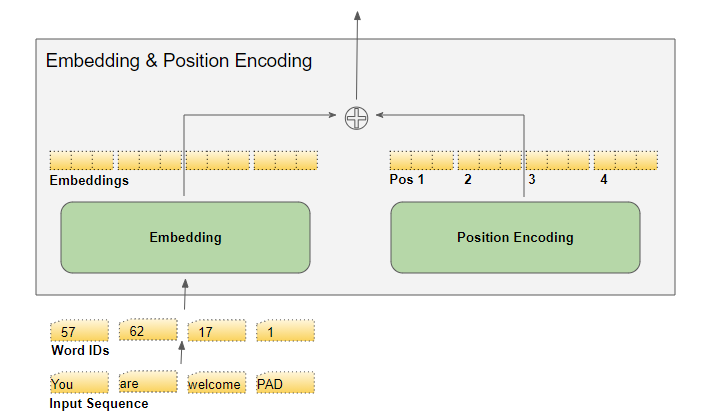

In [10]:
import numpy as np
class PositionalEncoding(layers.Layer):
  def __iniit__(self):
    super(PositionalEncoding,self).__init__()

  def calculate_angles(self, position, i, d_model):
    x = (2* (2//i))/ np.float32(d_model)
    angles = 1 / (np.power(10000.,x))
    return position * angles #dim = (seq_len, d_model)

  def call(self, inputs):
    seq_length = inputs.shape.as_list()[-2]
    d_model = inputs.shape.as_list()[-1]
    angles = self.calculate_angles(np.arange(seq_length)[:,np.newaxis],
                                   np.arange(d_model)[np.newaxis,:],
                                   d_model)
    angles[:,0::2]= np.sin(angles[:,0::2])
    angles[:,1::2]= np.cos(angles[:,1::2])
    positional_encoding = angles[np.newaxis, ...]
#    return positional_encoding
    return inputs + tf.cast(positional_encoding, tf.float32)

In [11]:
#x = tf.random.uniform((224,224,3))
#PE=PositionalEncoding()
#print(PE(x).shape)
#print(PE(x))

### The Encoder

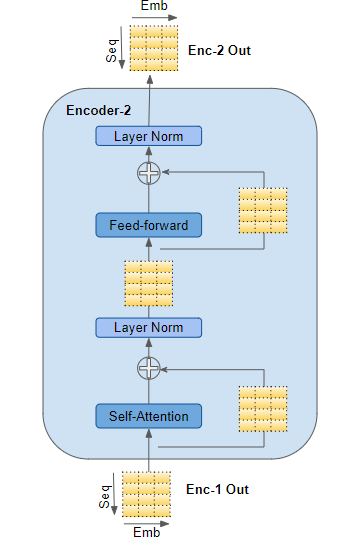

In [12]:
class EncoderLayer(layers.Layer):
  def __init__(self, n_head,dropout_rate, units):
    super(EncoderLayer, self).__init__()
    self.units= units
    self.dropout_rate = dropout_rate
    self.n_head = n_head

  def build(self, input_shape):
    self.d_model = input_shape[-1]
    self.multi_head_attention = multi_head_attention(self.n_head, self.d_model)
    self.dropout = layers.Dropout(rate=self.dropout_rate)
    self.norm = layers.LayerNormalization(epsilon=1e-6)
    self.linear1 = layers.Dense(self.units, activation="relu")    
    self.linear2 = layers.Dense(self.d_model)

  def call(self, inputs, mask, training):
#    print("Inputs shape ", inputs.shape)
    attention = self.multi_head_attention(inputs, inputs, inputs, mask)
#    print("ATTENTION :   ", attention.shape)

    attention = self.dropout(attention, training)
    attention = self.norm(attention + inputs)

    outputs = self.linear1(attention)
    outputs = self.linear2(outputs)
    outputs = self.dropout(outputs, training= training)
    outputs = self.norm(attention + outputs)
    return outputs 

In [13]:
class Encoder(keras.Model):
  def __init__(self,n_layers, units, n_head, dropout_rate,vocab_size, d_model):
    super(Encoder, self).__init__()
    self.n_head= n_head
    self.d_model= d_model
    self.n_layers = n_layers
    self.embedding = layers.Embedding(vocab_size,d_model)
    self.positional_encoding=PositionalEncoding()
    self.dropout = layers.Dropout(rate=dropout_rate)
    self.encoder_layers = [EncoderLayer(n_head, dropout_rate, units) for _ in range(n_layers)                           
    ]

  def call(self, inputs, mask, training):
    outputs = self.embedding(inputs)
#    print("Embedding:    ", outputs.shape)
    outputs = outputs * (tf.math.sqrt(tf.cast(self.d_model, tf.float32)))
    outputs = self.positional_encoding(outputs)
    outputs = self.dropout(outputs,training)
#    print("Positional Encodingggg:    ", outputs.shape)

    for i in range(self.n_layers):
      outputs = self.encoder_layers[i](outputs, mask, training)
    return outputs


In [14]:
#Test  
#encoder_inputs = tf.constant([[1,5,6,4,3,9,5,1],
#                              [1,8,7,3,4,5,6,3]],
#                             dtype=tf.float32)

#enc_test = Encoder(n_layers=6, units=50, n_head=2, dropout_rate=0.01, vocab_size=10,d_model=14)

#print(enc_test(encoder_inputs, None, True).shape)

### The Decoder

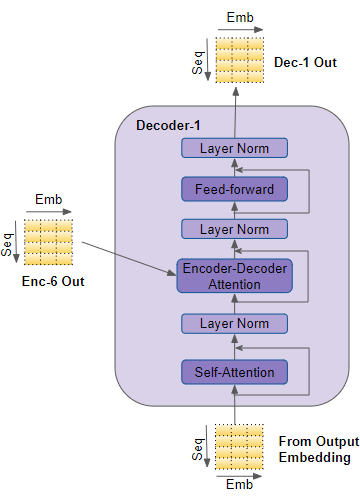

In [15]:
class DecoderLayer(layers.Layer):
  def __init__(self, n_head,dropout_rate, units):
    super(DecoderLayer, self).__init__()
    self.units= units
    self.dropout_rate = dropout_rate
    self.n_head = n_head

  def build(self, input_shape):
    self.d_model = input_shape[-1]
    self.casual_attention = multi_head_attention(self.n_head, self.d_model)
    self.encoder_decoder_attention = multi_head_attention(self.n_head,self.d_model)
    self.dropout = layers.Dropout(rate=self.dropout_rate)
    self.norm = layers.LayerNormalization(epsilon=1e-6)
    self.linear1 = layers.Dense(self.units, activation="relu")    
    self.linear2 = layers.Dense(self.d_model)

  def call(self, inputs,encoder_outpus, mask1,mask2, training):
    attention1 = self.casual_attention(inputs, inputs, inputs, mask1)
    attention1 = self.dropout(attention1, training)
    attention1 = self.norm(attention1 + inputs)

    attention2 = self.encoder_decoder_attention(attention1, encoder_outpus,encoder_outpus, mask2)
    attention2 = self.dropout(attention2, training)
    outputs = self.norm(attention2 + attention1)

    outputs = self.linear1(outputs)
    outputs = self.linear2(outputs)
    outputs = self.dropout(outputs, training= training)
    outputs = self.norm(attention2 + outputs)
    return outputs 

In [16]:
class Decoder(layers.Layer):
  def __init__(self, units,n_layers, n_head, dropout_rate,vocab_size, d_model):
    super(Decoder, self).__init__()
    self.n_layers = n_layers
    self.n_head= n_head
    self.d_model= d_model
    self.embedding = layers.Embedding(vocab_size,d_model)
    self.positional_encoding=PositionalEncoding()
    self.dropout = layers.Dropout(rate=dropout_rate)
    self.decoder_layers = [DecoderLayer(n_head, dropout_rate, units) for _ in range(n_layers)                           
    ]

  def call(self, inputs,encoder_outputs ,mask1,mask2, training):
    outputs = self.embedding(inputs)
    outputs = outputs * (tf.math.sqrt(tf.cast(self.d_model, tf.float32)))
    outputs = self.positional_encoding(outputs)
    print("outputs shape :  ", outputs.shape)
    outputs = self.dropout(outputs,training)
    for i in range(self.n_layers):
      outputs = self.decoder_layers[i](outputs,encoder_outputs, mask1,mask2, training)
    return outputs


![image.png](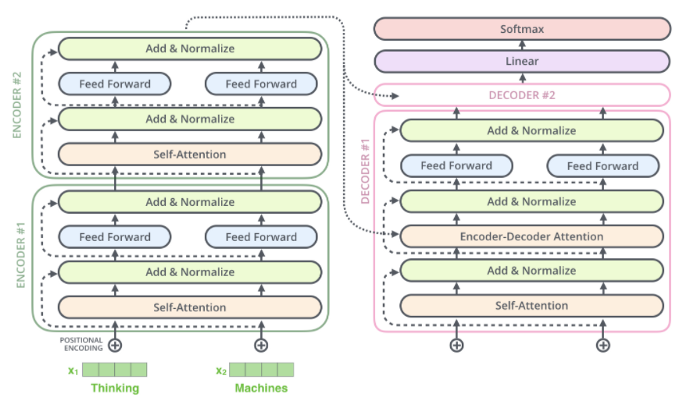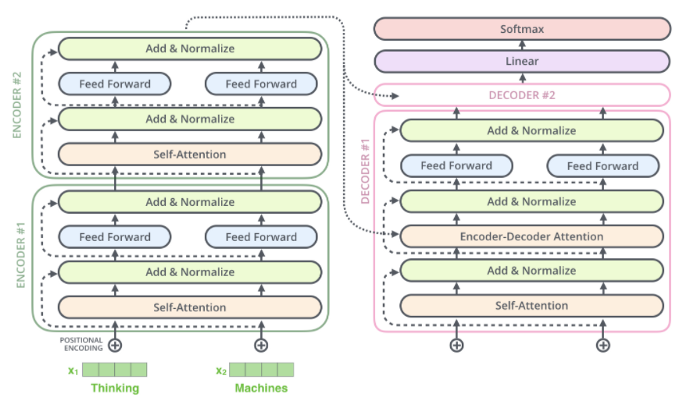)

### Transformer 

In [17]:
class Transformer (tf.keras.Model):
  def __init__(self, vocab_size_encoder, vocab_size_decoder, d_model, n_layers,units, n_head, dropout_rate, name="Transformer"):
    super(Transformer, self).__init__(name=name)
    self.encoder = Encoder(n_layers, units, n_head, dropout_rate, vocab_size_encoder, d_model)
    self.decoder = Decoder(units,n_layers , n_head, dropout_rate, vocab_size_decoder, d_model)
    self.dense_layer = layers.Dense(vocab_size_decoder) 


  def create_padding_mask(self, sequence):
    sequence = tf.cast(tf.math.equal(sequence, 0), tf.float32)
    return sequence[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

  def create_look_ahead_mask(self,sequence):
    sequence_length = tf.shape(sequence)[1]
    mask = 1 - tf.linalg.band_part(tf.ones((sequence_length, sequence_length)), -1, 0)
    return mask  # (seq_len, seq_len)
  
  def call(self, encoder_inputs, decoder_inputs, training):
    encoder_mask = self.create_padding_mask(encoder_inputs)
    decoder_mask1 = self.create_padding_mask(decoder_inputs)
    
    decoder_mask2 = tf.maximum(
        self.create_padding_mask(decoder_inputs),
        self.create_look_ahead_mask(decoder_inputs))
    
    
    encoder_outputs = self.encoder(encoder_inputs,
                                   encoder_mask, 
                                   training)
    
    decoder_outputs = self.decoder(inputs=decoder_inputs,
                                   encoder_outputs= encoder_outputs,
                                   mask1 = None, 
                                   mask2 = decoder_mask1,
                                   training = training)
    final_outputs  = self.dense_layer(decoder_outputs)

    return final_outputs

In [18]:
encoder_inputs = tf.constant([[1,5,6,4,3,9,5,1],
                              [1,8,7,3,4,5,6,3]],
                             dtype=tf.float32) 

In [19]:
decoder_inputs = tf.constant([[1,9,2,5,1,2,9,8],
                              [1,2,1,1,8,9,4,7]],
                             dtype=tf.float32) 

In [20]:
transformer = Transformer(vocab_size_encoder=10,
                          vocab_size_decoder=10,
                          d_model=14,
                          n_layers=5,
                          units=35,
                          n_head=2,
                          dropout_rate=0.01)

In [21]:
y = transformer(encoder_inputs=encoder_inputs,
                decoder_inputs=decoder_inputs,
                training=False)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in floor_divide
  import sys


outputs shape :   (2, 8, 14)


In [22]:
y.shape

TensorShape([2, 8, 10])

Other Links: 

https://www.youtube.com/watch?v=U0s0f995w14

https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853

https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634

